In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [120]:
df = yf.download(tickers = "FROTO.IS",
                 start = "2016-01-01",
                 end= "2022-10-19",
                 interval="1d",
                 group_by="ticker",
                 auto_adjust=True,
                 treads=True)

[*********************100%***********************]  1 of 1 completed


In [121]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-01 00:00:00+02:00,20.329802,20.329802,20.329802,20.329802,0
2016-01-04 00:00:00+02:00,20.141813,20.464081,19.779259,20.370087,282258
2016-01-05 00:00:00+02:00,20.477510,20.571505,19.792689,20.343231,324771
2016-01-06 00:00:00+02:00,20.276090,20.531219,20.074672,20.396940,373568
2016-01-07 00:00:00+02:00,20.289520,20.477511,19.819545,20.437227,546437


In [122]:
df["froto"] = df.Close
df["volume"] = df.Volume
del df["Open"], df["High"], df["Close"], df["Volume"], df["Low"]

In [123]:
df.head()

,froto,volume
Date,,
2016-01-01 00:00:00+02:00,20.329802,0
2016-01-04 00:00:00+02:00,20.370087,282258
2016-01-05 00:00:00+02:00,20.343231,324771
2016-01-06 00:00:00+02:00,20.396940,373568
2016-01-07 00:00:00+02:00,20.437227,546437


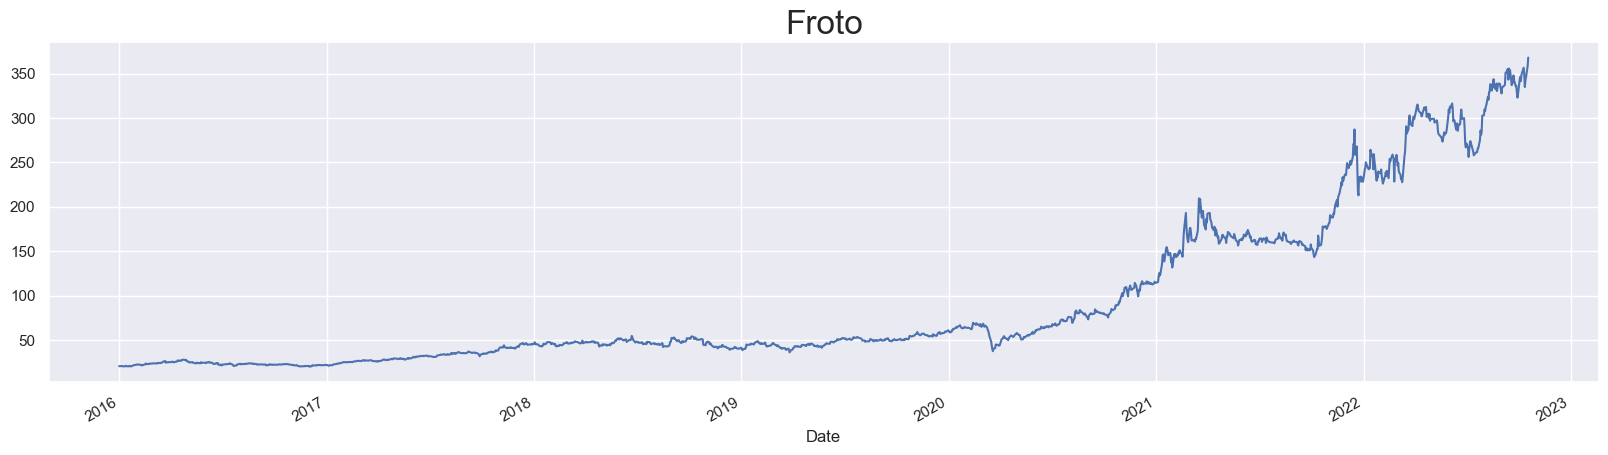

In [124]:
df.froto.plot(figsize = (20,5))
plt.title("Froto", size = 24)
plt.show()

In [125]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [126]:
df.froto = df.froto.asfreq('b')

In [127]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [128]:
df = df.fillna(method="ffill")

In [129]:
df.isnull().sum()

froto     0
volume    0
dtype: int64

In [130]:
sts.adfuller(df.froto)

(2.0972098063339484,
 0.9987866864486373,
 3,
 1738,
 {'1%': -3.4341181153766156,
  '5%': -2.863204412766938,
  '10%': -2.5676560852851247},
 9345.944962914782)

In [131]:
s_dec_multiplicative = seasonal_decompose(df.froto, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
sgt.plot_acf(df.froto, lags = 40, zero = False)
plt.title("ACF Froto", size = 24)
plt.ylim(-0.5,1.1)
plt.show()

In [ ]:
sgt.plot_pacf(df.froto, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Froto", size = 24)
plt.ylim(-0.2,1.1)
plt.show()

In [ ]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
df['returns'] = df.froto.pct_change(1)*100

In [ ]:
model_ar_1_i_1_ma_1 = ARIMA(df.froto, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

In [ ]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.ylim(-0.1,0.1)
plt.show()

In [ ]:
results_ar_1_i_1_ma_1.summary()

In [ ]:
df['delta_prices']=df.froto.diff(1)

In [ ]:
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

In [ ]:
sts.adfuller(df.delta_prices[1:])

In [ ]:
df['results_delta_ar_1_i_1_ma_1'] = results_delta_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.results_delta_ar_1_i_1_ma_1[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20),
plt.ylim(-0.09,0.09)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model_sarimax = SARIMAX(df.froto, exog = df.volume, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()